In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [2]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 24.29%
Test size ≃ 75.71%


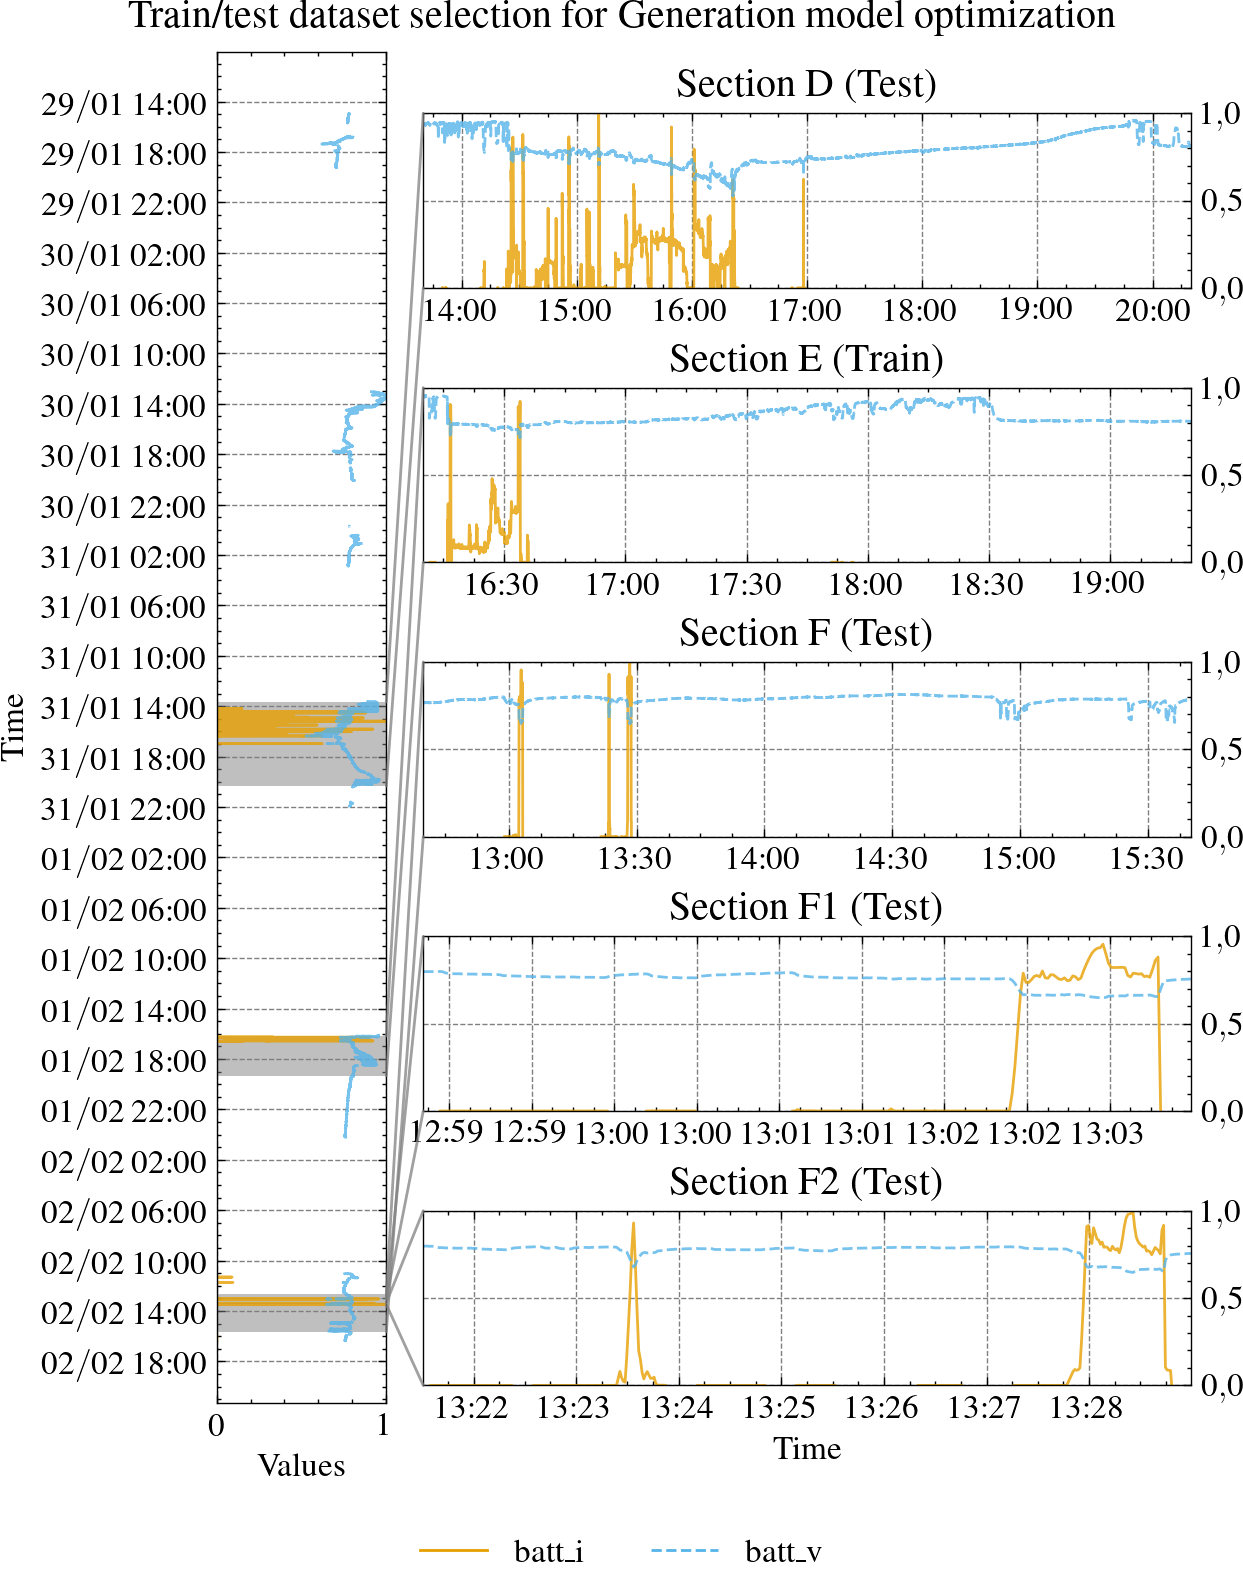

In [19]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
# sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
# sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
# sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
sections = sections.loc[['Section D', 'Section E', 'Section F', 'Section F1', 'Section F2']]

train_section_name = 'Section E'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )


# Battery Equivalent Circuit Model


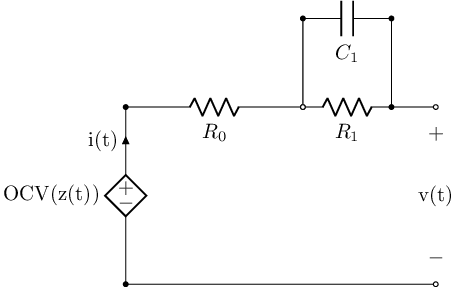

In [20]:
# %pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca

circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    draw_nodes=True,
    label_nodes=False,
    label_ids=True,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

circuit = lca.Circuit("""
E1 R0.1 0 2 0; down, l={OCV(z(t))}, i>={i(t)}
R0 .1 .2; right
R1 R0.2 .2; right=0.5
C1 .1 .2; right=0.5
W R1.1 C1.1; up=0.5
W R1.2 C1.2; up=0.5
W R1.2 P1.1; right=0.25
P1 .1 0_2; down, v={v(t)}
W 0 0_2; right
;""")
circuit.draw(**circuit_draw_params)
circuit.draw(**circuit_draw_params, filename="/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/battery_model.png")


![](feZkCLr.png)

De acordo com [Mateo Basic](https://www.sciencedirect.com/science/article/pii/S2405896322003469), as seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{dv_{C_{1}}(t) }{ dt } &=
        -\frac{ v_{C_{1}}(t) }{ R_{1} C_{1} }
        +\frac{ i(t) }{ C_{1} } \\
    \frac{ dv_{C_{0}}(t) }{ dt } &=
        \frac{ i(t) }{ C_{0} } \\
    v(t) &= 
        -v_{C_{0}}
        -v_{C_{1}}
        -R_{0} i(t)
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

In [21]:
import control as ct

def eval_poly(coeffs, x):
    result = 0.0
    for c in reversed(coeffs[1:]):
        result = (result + c) * x
    return result + coeffs[0]

class Battery:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        # Params
        batt_R_1 = params['batt_R_1']  # RC1 resistance [Ω]
        batt_R_2 = params['batt_R_2']  # RC2 resistance [Ω]
        batt_R_3 = params['batt_R_3']  # RC3 resistance [Ω]
        batt_N_S = params['batt_N_S']  # number of 12 V blocks in series

        # Input Initial Conditions
        batt_z_0 = X0['batt_z']  # Initial SoC
        batt_v_0 = X0.get('batt_v', 0.0)  # Initial battery voltage

        # Inputs
        batt_i_0 = U0[0]  # Battery current [A]

        # Outputs
        batt_r = np.array([batt_R_1, batt_R_2, batt_R_3])
        batt_v_c_hat = batt_r * batt_i_0
        y = cls._outputs(t=0, x=np.array([batt_z_0, batt_v_c_hat[0], batt_v_c_hat[1], batt_v_c_hat[2]]), u=U0, params=params)
        batt_v_0_hat = y[0]  # battery voltage as if there was no initial condition

        # Distribute correction across RC branches.
        weights = batt_r / batt_r.sum() # sum(weights) = 1

        # ΔvC = -dv * weights ensures sum(ΔvC) = -dv
        dv = batt_v_0 - batt_v_0_hat  # [V]
        dvC = -dv * weights

        batt_v_C_1_0, batt_v_C_2_0, batt_v_C_3_0 = batt_v_c_hat + (dvC / batt_N_S)

        return np.array([batt_z_0, batt_v_C_1_0, batt_v_C_2_0, batt_v_C_3_0])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_eta = params['batt_eta']
        batt_Q = params['batt_Q']
        batt_R_1 = params['batt_R_1']
        batt_R_2 = params['batt_R_2']
        batt_R_3 = params['batt_R_3']
        batt_tau_1 = params['batt_tau_1']   # time constant RC1 [s]
        batt_tau_2 = params['batt_tau_2']   # time constant RC2 [s]
        batt_tau_3 = params['batt_tau_3']   # time constant RC3 [s]

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        # batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_2 = x[2]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_3 = x[3]  # battery voltage through the internal serie-parallel resistance [V]

        # System of differential equations
        d_batt_z = -batt_eta * batt_i / batt_Q
        d_batt_v_C_1 = (batt_i * batt_R_1 - batt_v_C_1) / batt_tau_1
        d_batt_v_C_2 = (batt_i * batt_R_2 - batt_v_C_2) / batt_tau_2
        d_batt_v_C_3 = (batt_i * batt_R_3 - batt_v_C_3) / batt_tau_3

        return np.array([d_batt_z, d_batt_v_C_1, d_batt_v_C_2, d_batt_v_C_3])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        batt_N_S = params['batt_N_S']
        batt_k_V_OC_coeffs = params['batt_k_V_OC_coeffs']
        batt_R_0 = params['batt_R_0']

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_2 = x[2]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_3 = x[3]  # battery voltage through the internal serie-parallel resistance [V]

        # Output equations
        batt_ocv = eval_poly(batt_k_V_OC_coeffs, batt_z)
        # batt_v = batt_N_S*(batt_ocv - batt_v_C_1 - batt_v_C_2 - batt_R_0 * batt_i)
        batt_v = batt_N_S * (batt_ocv - batt_v_C_3 - batt_v_C_1 - batt_v_C_2 - batt_R_0 * batt_i)

        return np.array([batt_v, batt_z, batt_ocv])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='battery',
            states=('batt_z', 'batt_v_C_1', 'batt_v_C_2', 'batt_v_C_3'),
            inputs=('batt_i',),
            outputs=('batt_v', 'batt_z', 'batt_ocv'),
            params=params,
        )

Battery.build({})

<NonlinearIOSystem:battery:['batt_i']->['batt_v', 'batt_z', 'batt_ocv']>

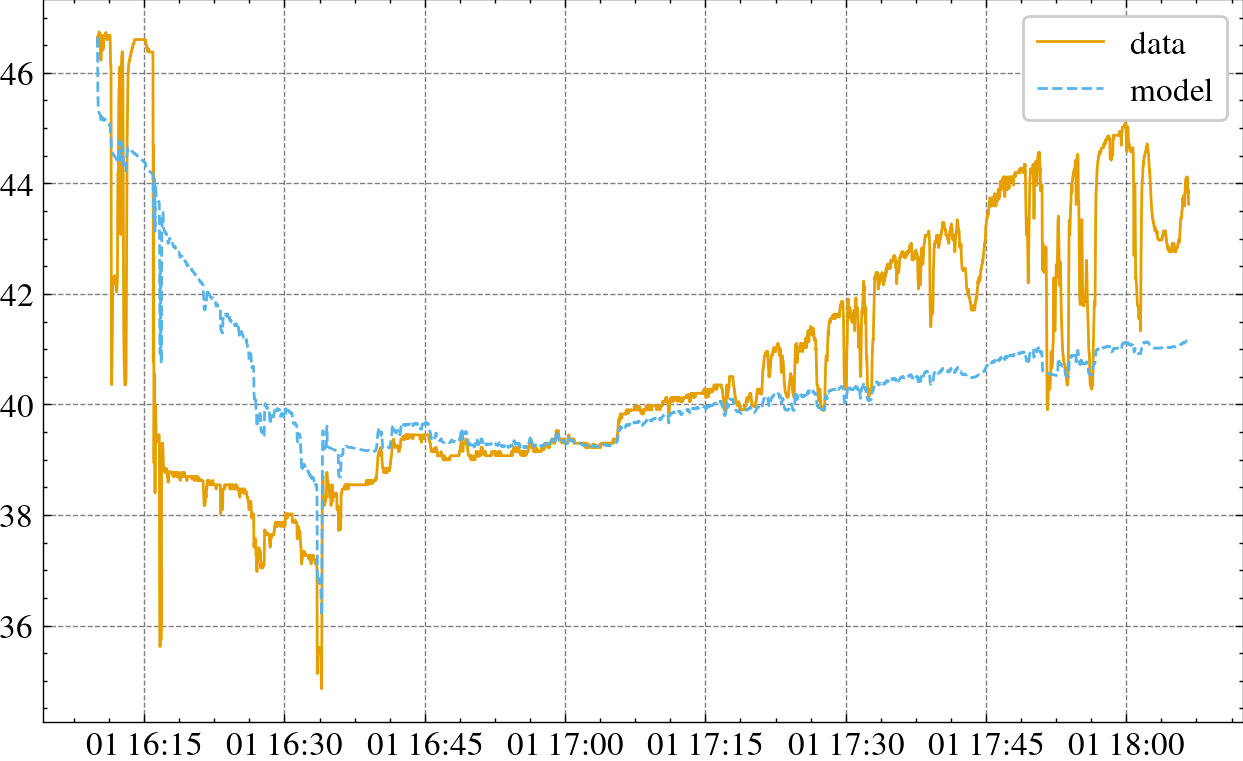

In [22]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1
nominal_voltage = series_cells * cell_voltage
batt_k_V_OC_coeffs = np.array([10.7864583333, 3.5863893517, -3.0753011401, 1.6163721814])

battery_params = {
    'batt_N_S': series_cells,
    'batt_eta': 1,
    'batt_Q': cell_amps_hour * 3600,
    'batt_R_0': 3e-3,
    'batt_R_1': 5e-3,
    'batt_R_2': 2e-3,
    'batt_R_3': 2e-2,
    'batt_tau_1': 2,
    'batt_tau_2': 900,
    'batt_tau_3': 1800,
    'batt_k_V_OC_coeffs': batt_k_V_OC_coeffs,
}

# Select the optimization data
data_cols = ['batt_v']
input_cols = ['batt_i']

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:7000]

# Time array
T = np.ascontiguousarray(df_train['t'].to_numpy())

# Inputs
U = np.ascontiguousarray(df_train[['batt_i']].to_numpy().T)

# Model
battery = Battery.build(battery_params)

# Initial state
X0 = Battery.initial_state(
    X0={
        'batt_z': 0.82,
        'batt_v': df_train['batt_v'].iloc[0],
    },
    U0=U[:,0],
    params=battery_params
)

# Simulation
res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

plt.plot(df_train.index, df_train['batt_v'], label='data')
plt.plot(df_train.index, ydata['batt_v'], label='model')
plt.legend(loc='upper right')
plt.show()

## Frequency view

# Optimization

In [23]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

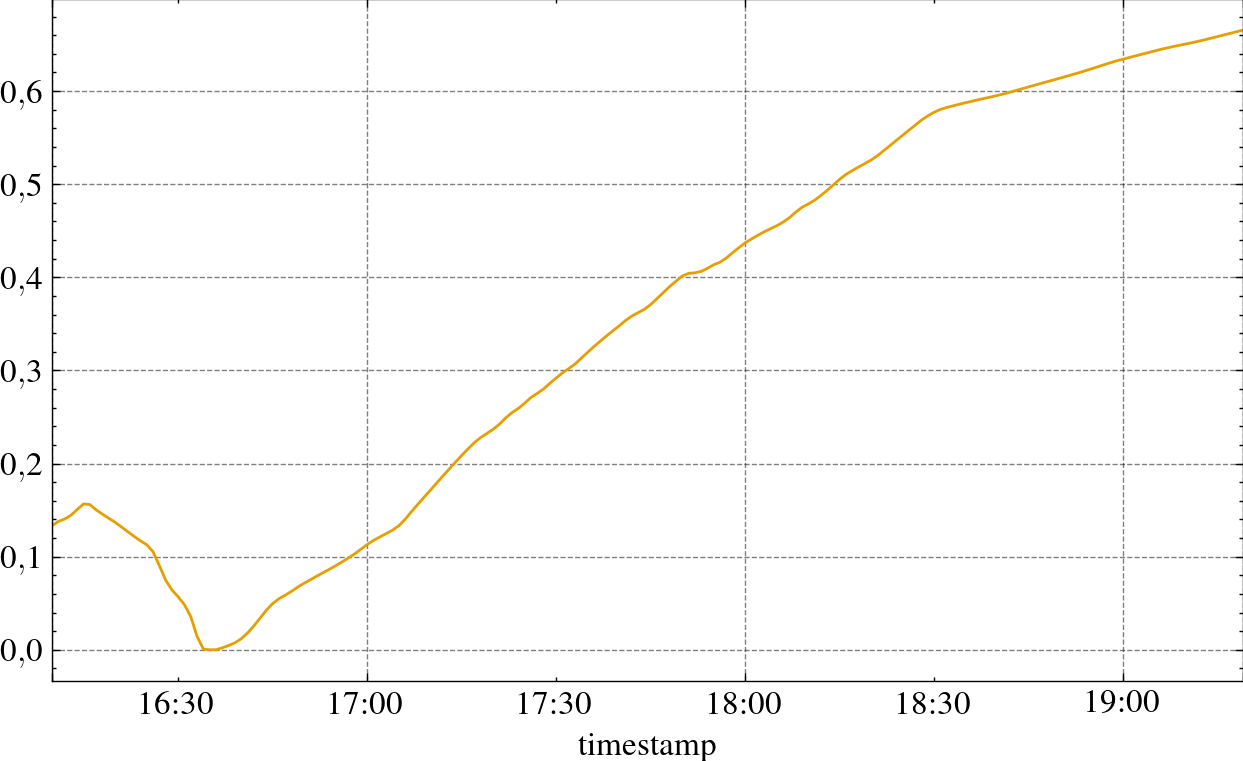

In [24]:
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols].resample('1min').mean().interpolate(method='time')
compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
# df_train['batt_z'] = (df_train['batt_z'] - df_train['batt_z'].min()) / (df_train['batt_z'].max() - df_train['batt_z'].min())
df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()
df_train['batt_z'].plot()
plt.show()

In [25]:
from dataclasses import dataclass, field
from typing import List, Literal
import numpy as np


ConstraintKind = Literal[
    "tau_order",
    "tau_gap",
    "C_order",
    "R_order",
    "ocv_deriv",
]


@dataclass
class ParamConstraint:
    """
    Generic constraint usable by pymoo: g(x) <= 0 when satisfied.
    Picklable (no closures), works with multiprocessing.
    """
    kind: ConstraintKind

    # indices into the decision vector x
    idx_a: int | None = None   # e.g. tau1 or R0 index
    idx_b: int | None = None   # e.g. tau2 or R1 index
    idx_c: int | None = None   # second R index for C_order, if needed

    # gap for tau constraints
    gap: float = 1.0

    # OCV derivative constraints
    ocv_indices: List[int] = field(default_factory=list)  # indices of coeffs a0..aN
    z: float | None = None       # SOC point
    min_slope: float = 0.0       # minimum allowed dU/dz

    def __call__(self, x: np.ndarray) -> float:
        if self.kind == "tau_order":
            # tau_a < tau_b -> tau_a - tau_b <= 0
            return x[self.idx_a] - x[self.idx_b]

        if self.kind == "tau_gap":
            # tau_b >= gap * tau_a -> gap*tau_a - tau_b <= 0
            return self.gap * x[self.idx_a] - x[self.idx_b]

        if self.kind == "C_order":
            # C_a = tau_a / R_a ; C_b = tau_b / R_b
            # Enforce C_a < C_b -> C_a - C_b <= 0
            tau_a = x[self.idx_a]
            R_a   = x[self.idx_b]
            tau_b = x[self.idx_c]
            # infer R_b index as "idx_c+1" would be fragile; we just store explicitly:
            # here we assume idx_a=tau_i, idx_b=R_i, idx_c=tau_j, and idx_d=R_j
            # To avoid extra field, we encode as:
            #   idx_a = tau_i, idx_b = R_i, idx_c = tau_j
            #   and use the next field in ocv_indices[0] for R_j (see builder below).
            # But that’s too hacky. Instead, use: idx_a=tau_i, idx_b=R_i, idx_c=tau_j
            # and store R_j index in ocv_indices[0].
            R_b   = x[self.ocv_indices[0]]  # reused as a generic extra index slot

            C_a = tau_a / R_a
            C_b = tau_b / R_b
            return C_a - C_b

        if self.kind == "R_order":
            # R_a < R_b -> R_a - R_b <= 0
            return x[self.idx_a] - x[self.idx_b]

        if self.kind == "ocv_deriv":
            # dU/dz >= min_slope -> min_slope - dU/dz <= 0
            a = np.array([x[i] for i in self.ocv_indices])  # coeffs a0..aN
            deriv = 0.0
            for k in range(1, len(a)):
                deriv += k * a[k] * (self.z ** (k - 1))
            return self.min_slope - deriv

        return 0.0


def build_battery_constraints(
    params_bounds: dict,
    gap: float = 1.2,
    use_ocv_monotonic: bool = False,
    ocv_prefix: str = "batt_k_V_OC_coeffs",
    z_points: np.ndarray | None = None,
    ocv_min_slope: float = 0.0,
) -> list[ParamConstraint]:
    """
    Build constraints for 3-RC PNGV battery model using *ordering only*.

    Enforces:

        tau_1 < tau_2 < tau_3
        tau_2 >= gap * tau_1
        tau_3 >= gap * tau_2

        C_1 < C_2 < C_3      with C_i = tau_i / R_i

        R_0 < R_1 < R_2 < R_3

    Optionally enforces monotonic OCV polynomial.
    """
    names = list(params_bounds.keys())
    idx = {name: i for i, name in enumerate(names)}

    cons: list[ParamConstraint] = []

    # --- tau ordering + gaps ---
    cons.append(ParamConstraint(
        "tau_order",
        idx_a=idx["batt_tau_1"],
        idx_b=idx["batt_tau_2"],
    ))
    cons.append(ParamConstraint(
        "tau_order",
        idx_a=idx["batt_tau_2"],
        idx_b=idx["batt_tau_3"],
    ))
    cons.append(ParamConstraint(
        "tau_gap",
        idx_a=idx["batt_tau_1"],
        idx_b=idx["batt_tau_2"],
        gap=gap,
    ))
    cons.append(ParamConstraint(
        "tau_gap",
        idx_a=idx["batt_tau_2"],
        idx_b=idx["batt_tau_3"],
        gap=gap,
    ))

    # --- C ordering: C1 < C2 < C3, where Ci = tau_i / R_i ---
    # For each constraint we store:
    #   tau_i index in idx_a, R_i index in idx_b,
    #   tau_j index in idx_c, R_j index in ocv_indices[0].
    cons.append(ParamConstraint(
        "C_order",
        idx_a=idx["batt_tau_1"],
        idx_b=idx["batt_R_1"],
        idx_c=idx["batt_tau_2"],
        ocv_indices=[idx["batt_R_2"]],
    ))
    cons.append(ParamConstraint(
        "C_order",
        idx_a=idx["batt_tau_2"],
        idx_b=idx["batt_R_2"],
        idx_c=idx["batt_tau_3"],
        ocv_indices=[idx["batt_R_3"]],
    ))

    # --- R ordering: R0 < R1 < R2 < R3 ---
    cons.append(ParamConstraint(
        "R_order",
        idx_a=idx["batt_R_0"],
        idx_b=idx["batt_R_1"],
    ))
    cons.append(ParamConstraint(
        "R_order",
        idx_a=idx["batt_R_1"],
        idx_b=idx["batt_R_2"],
    ))
    cons.append(ParamConstraint(
        "R_order",
        idx_a=idx["batt_R_2"],
        idx_b=idx["batt_R_3"],
    ))

    # --- optional: monotonic OCV polynomial ---
    if use_ocv_monotonic:
        # gather coefficient indices a0..aN in order
        ocv_indices = []
        for name in names:
            if name.startswith(ocv_prefix + "_"):
                k = int(name[len(ocv_prefix) + 1 :])
                ocv_indices.append((k, idx[name]))
        if ocv_indices:
            ocv_indices_sorted = [j for (k, j) in sorted(ocv_indices, key=lambda t: t[0])]
            if z_points is None:
                z_points = np.linspace(0.0, 1.0, 9)
            for z in z_points:
                cons.append(
                    ParamConstraint(
                        "ocv_deriv",
                        ocv_indices=ocv_indices_sorted,
                        z=float(z),
                        min_slope=ocv_min_slope,
                    )
                )

    return cons


In [26]:
class BatteryWithSocOptimizationProblem(ElementwiseProblem):
    def __init__(
        self,
        model,
        model_function,
        training_data,
        training_data_columns,
        model_params,
        opt_params_bounds,
        input_columns,
        nominal_Q,
        data_scaler=RobustScaler,
        constraint_funcs=None,
        print_exceptions=False,
        **kwargs,
    ):
        assert all(
            "min" in pb and "max" in pb for pb in opt_params_bounds.values()
        ), "All opt_params_bounds must have 'min' and 'max' keys"

        self.model = model
        self.model_function = model_function
        self.model_params = model_params
        self.data_scaler_cls = data_scaler
        self.training_data_columns = training_data_columns  # e.g. ['batt_v', 'batt_z']
        self.opt_param_names = list(opt_params_bounds.keys())
        self.input_columns = input_columns
        self.print_exceptions = print_exceptions
        self.constraint_funcs = constraint_funcs or []
        self.nominal_Q = nominal_Q

        # Keep the raw training data (no batt_z yet)
        self.training_data_raw = training_data.copy(deep=True)

        # Time vector
        dt = (training_data.index[1] - training_data.index[0]).total_seconds()
        self.T = np.linspace(0, len(training_data) * dt, len(training_data), endpoint=False)

        # Inputs
        self.U = training_data[input_columns].to_numpy().T

        # --- Fit scaler once using a baseline initial_SOC0 (e.g. 0.5) ---
        df0 = self.training_data_raw.copy()
        initial_SOC0 = 0.5
        compute_df_capacity(df0, self.nominal_Q, initial_SOC0, inplace=True)
        compute_df_soc(df0, self.nominal_Q, inplace=True)
        Y0 = df0[self.training_data_columns].to_numpy()
        self.data_scaler = self.data_scaler_cls().fit(Y0)

        super().__init__(
            n_var=len(self.opt_param_names),
            n_obj=1,
            n_constr=len(self.constraint_funcs),
            xl=np.array([p["min"] for p in opt_params_bounds.values()]),
            xu=np.array([p["max"] for p in opt_params_bounds.values()]),
            **kwargs,
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = self.objective_function(x, *args, **kwargs)

        if self.constraint_funcs:
            # Each constraint func should return a scalar ≤ 0 when satisfied
            g = [func(x) for func in self.constraint_funcs]
            out["G"] = np.array(g)

    def objective_function(self, x, *args, **kwargs):
        # Map decision vector to parameters
        params_dict = {name: x[i] for i, name in enumerate(self.opt_param_names)}
        batt_z_0 = params_dict.pop('batt_z')  # remove from model params
        model_params = self.model_params | convert_to_model_params(params_dict)

        # Recompute SOC trajectory from candidate batt_z_0
        df_temp = self.training_data_raw.copy()
        compute_df_capacity(df_temp, self.nominal_Q, batt_z_0, inplace=True)
        compute_df_soc(df_temp, self.nominal_Q, inplace=True)

        # Ground truth (voltage + SOC) for this candidate
        y_true = df_temp[self.training_data_columns].to_numpy()
        scaled_y_true = self.scale_data(y_true)

        # Initial state
        X0 = self.model.initial_state(
            X0={
                'batt_z': df_temp['batt_z'].iloc[0],
                'batt_v': df_temp['batt_v'].iloc[0],
            },
            U0=self.U[:, 0],
            params=model_params,
        )

        # Run the simulation
        try:
            model_predictions = self.model_function(
                T=self.T, U=self.U, X0=X0, **model_params
            )[self.training_data_columns].to_numpy()
        except Exception as e:
            if self.print_exceptions:
                print(f"Exception from model_function: {e}")
            return 1e9  # Penalize parameters that break the model

        # Scale model predictions
        scaled_model_predictions = self.scale_data(model_predictions)

        return mean_squared_error(scaled_y_true, scaled_model_predictions)

    def scale_data(self, data):
        return self.data_scaler.transform(data)

    def rescale_data(self, data):
        return self.data_scaler.inverse_transform(data)


n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       80 |  0.000000E+00 |  2.739033E+03 |  0.1275794505 |  0.0402446988
     2 |      160 |  0.000000E+00 |  3.108292E+02 |  0.1214526586 |  0.0402446988
     3 |      240 |  0.000000E+00 |  0.0120045854 |  0.1136567289 |  0.0157972689
     4 |      320 |  0.000000E+00 |  0.0028391224 |  0.1137620950 |  0.0157972689
     5 |      400 |  0.000000E+00 |  0.0012921229 |  0.0968801698 |  0.0157972689
     6 |      480 |  0.000000E+00 |  0.0003088842 |  0.0905565942 |  0.0157972689
     7 |      560 |  0.000000E+00 |  0.0001490607 |  0.0771371319 |  0.0144058979
     8 |      640 |  0.000000E+00 |  0.0000878426 |  0.0664874839 |  0.0144058979
     9 |      720 |  0.000000E+00 |  0.000000E+00 |  0.0547304244 |  0.0140716502
    10 |      800 |  0.000000E+00 |  0.000000E+00 |  0.0465550141 |  0.0127250451
    11 |      880 |  0.000000E+00 |  0.000000E+00 |  0.0376823886 |  0.0127250451
    12 |      96

{'batt_R_0': 0.003,
 'batt_R_1': 0.005,
 'batt_R_2': 0.002,
 'batt_R_3': 0.02,
 'batt_tau_1': 2,
 'batt_tau_2': 900,
 'batt_tau_3': 1800}

Best parameters found:


{'batt_R_0': 0.012719707111981447,
 'batt_R_1': 0.01861394695845797,
 'batt_R_2': 0.030608625098018857,
 'batt_R_3': 0.05838847894747054,
 'batt_tau_1': 12.990557929357784,
 'batt_tau_2': 1599.4928932200996,
 'batt_tau_3': 3054.661855754557}

Objective value at solution: [0.00972321]


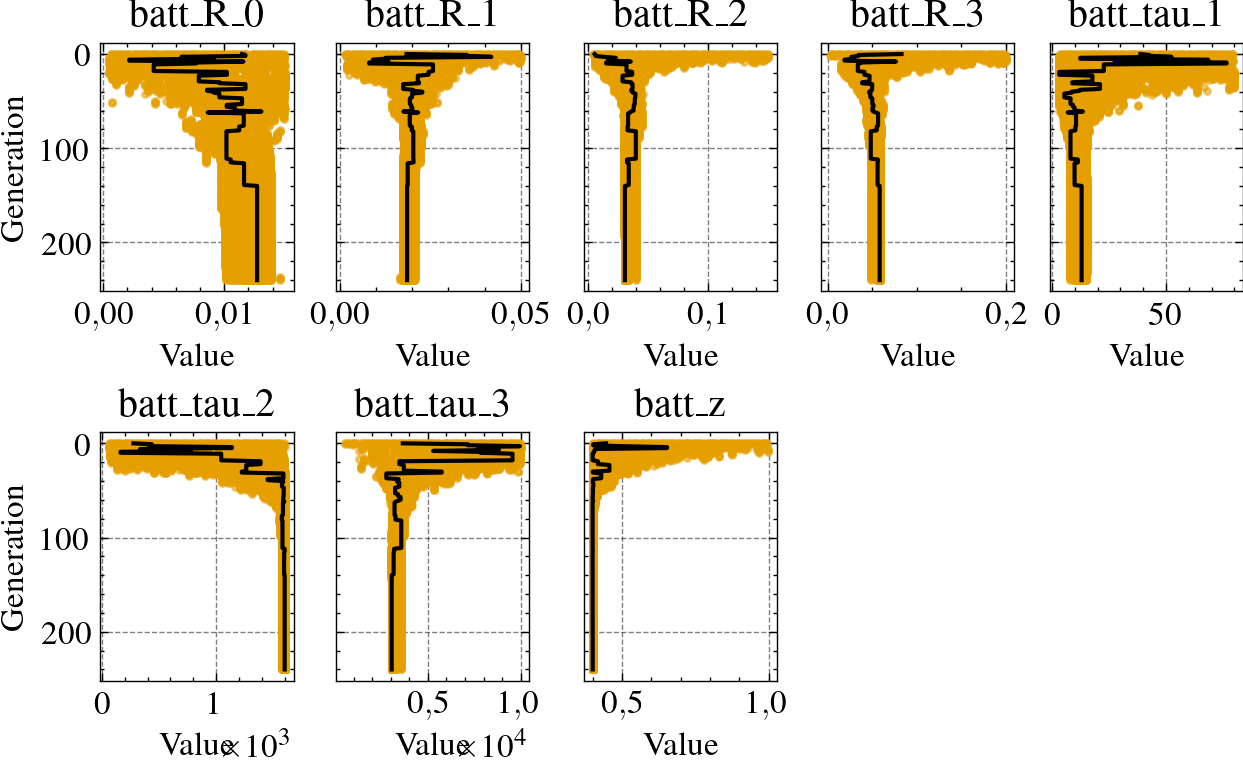

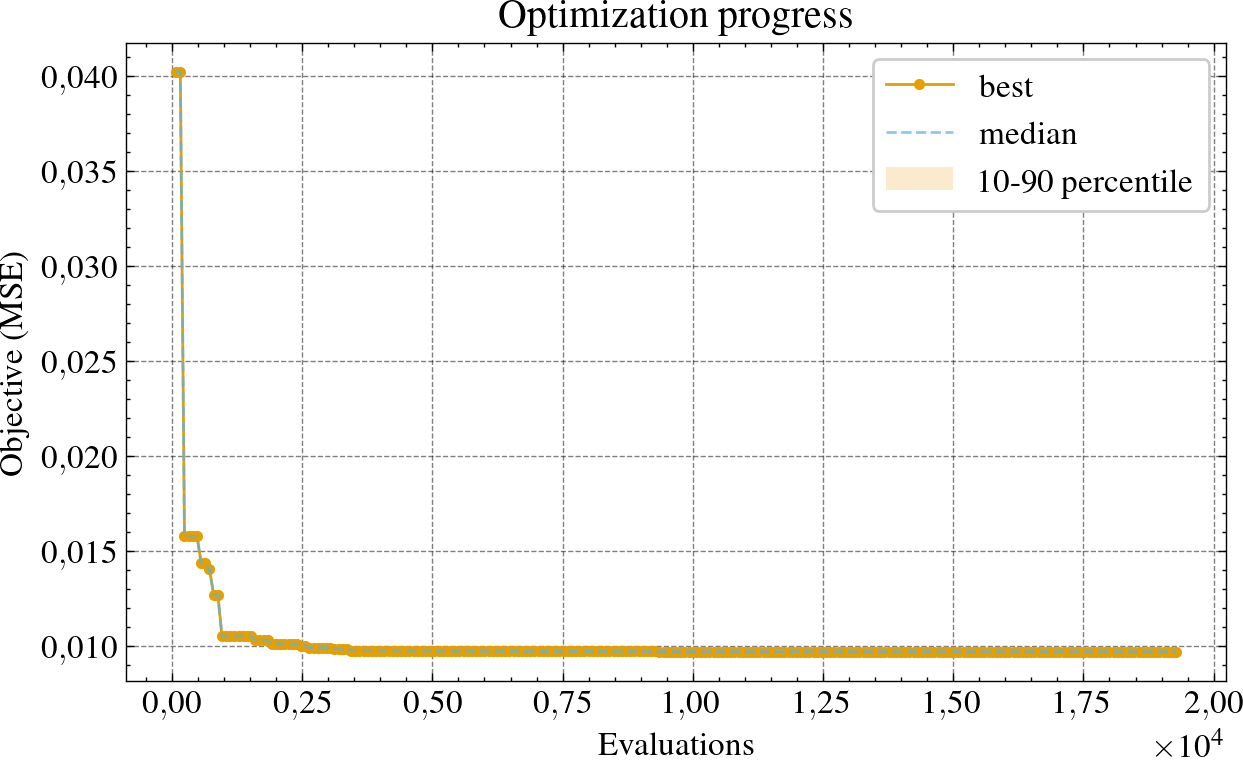

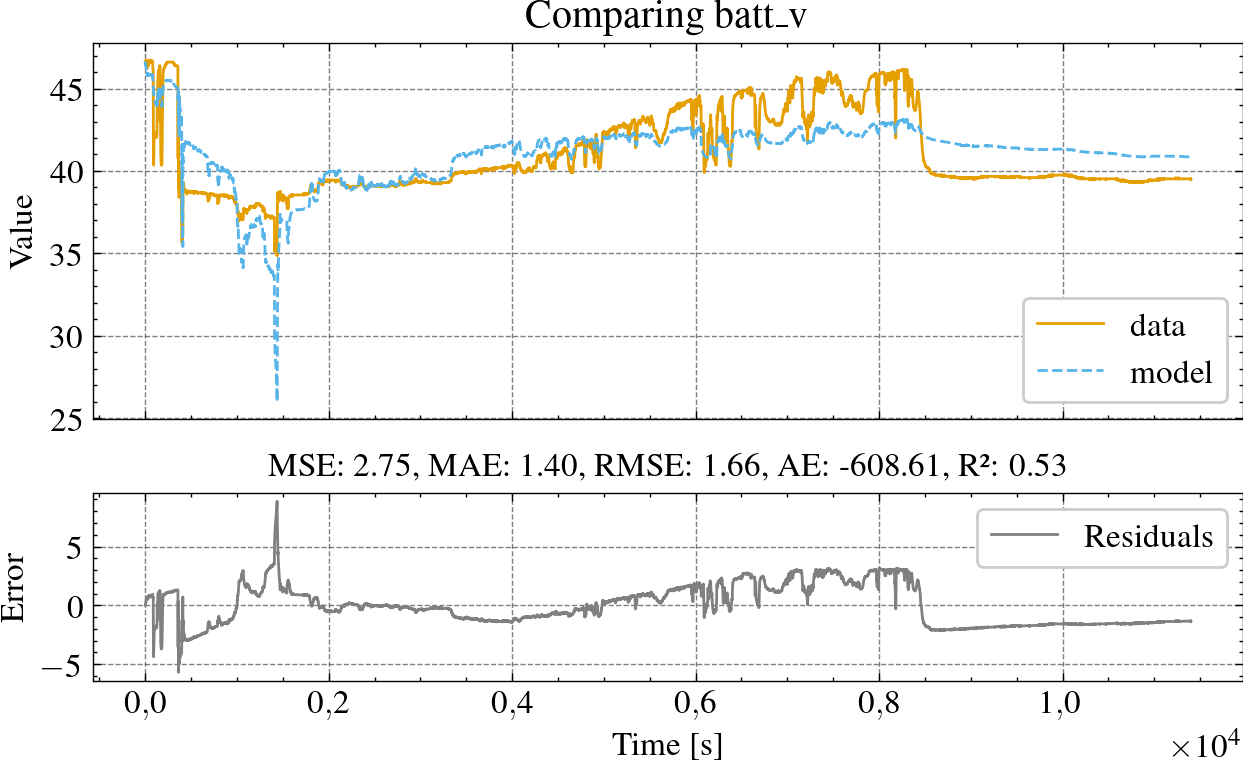

CPU times: user 14.8 s, sys: 4.65 s, total: 19.5 s
Wall time: 11min 57s


In [27]:
%%time

def run_battery_with_soc_optimization(
    model,
    model_params,
    df,
    train_section,
    nominal_Q,
    series_cells,
    model_function,
):
    # Define optimization and input data columns
    data_cols = ['batt_v', 'batt_z']   # now we fit batt_z as well
    input_cols = ['batt_i']

    # Extract and resample training data (no batt_z yet)
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + ['batt_v'] + input_cols
    ].resample('1s').mean().interpolate(method='time')

    # Initialize parameter bounds for the optimization
    params_bounds = {
        'batt_R_0':   dict(min=5e-4,  max=1.5e-2),

        'batt_R_1':   dict(min=1e-3,  max=5e-2),
        'batt_R_2':   dict(min=2e-3,  max=1.5e-1),
        'batt_R_3':   dict(min=2e-3,  max=2e-1),

        'batt_tau_1': dict(min=  3, max=  80),     # fast: around 10–20 s
        'batt_tau_2': dict(min= 60, max=1600),     # slow: around 300–800 s
        'batt_tau_3': dict(min=500, max=10000),    # very slow: structural prior

        'batt_z':     dict(min=0.4,   max=1.0),
    }

    poly_coeffs = [
        # {'name': 'batt_k_V_OC_coeffs', 'n_coeffs': 5, 'x_interval': (0, 1), 'y_bounds': (10.5, 13.5)},
    ]
    for coeff in poly_coeffs:
        name = coeff['name']
        n_coeffs = coeff['n_coeffs']
        y_bounds = coeff['y_bounds']
        coeff_bounds = estimate_polynomial_coefficient_bounds(
            x_interval=(0, 1), y_bounds=y_bounds, degree=(n_coeffs - 1)
        )
        for i in range(n_coeffs):
            params_bounds[f'{name}_{i}'] = dict(min=coeff_bounds[i][0], max=coeff_bounds[i][1])

    constraint_funcs = build_battery_constraints(
        params_bounds,
        gap=1.2,
        use_ocv_monotonic=['batt_ocv_coeff_0' in params_bounds]
    )

    # Initialize the multiprocessing pool and parallel runner
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)

    # Set up the optimization problem
    problem = BatteryWithSocOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_columns=input_cols,
        nominal_Q=nominal_Q,
        data_scaler=MinMaxScaler,
        constraint_funcs=constraint_funcs,
        elementwise_runner=runner,
    )

    # Configure the optimization algorithm (Differential Evolution in this case)
    algorithm = DE(
        pop_size=10 * len(params_bounds),
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.5,
        CR=0.9,
    )

    # Set termination criteria
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=100,
        n_max_gen=10000,
        n_max_evals=1000000,
    )

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )

    pool.close()
    pool.join()

    return result, params_bounds

model = Battery
model_params = battery_params
result, params_bounds = run_battery_with_soc_optimization(
    model=model,
    model_params=model_params,
    df=df,
    train_section=train_section,
    nominal_Q=nominal_Q,
    series_cells=series_cells,
    model_function=model_function,
)

# Retrieve and display the best parameters
raw_params = {k: result.X[i] for i, k in enumerate(params_bounds.keys())}
optimized_initial_SOC = raw_params.pop('batt_z', initial_SOC)
print('optimized_initial_SOC:', optimized_initial_SOC)
best_params = convert_to_model_params(raw_params)
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

# Plot optimization results
plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

# Simulate the model with the optimized parameters
df_train = df.loc[
    (df.index >= train_section['start']) & (df.index <= train_section['end']),
    ['t'] + data_cols + input_cols
].resample('1s').mean().interpolate(method='time')
compute_df_capacity(df_train, nominal_Q, optimized_initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
T = np.ascontiguousarray(df_train['t'].to_numpy())
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
X0 = Battery.initial_state(
    X0={
        'batt_z': df_train['batt_z'].iloc[0],
        'batt_v': df_train['batt_v'].iloc[0],
    },
    U0=U[:, 0],
    params=model_params | best_params
)
best_fit_data = model_function(T, U, X0, **(model_params | best_params))

# Plot the comparison for each data column
for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

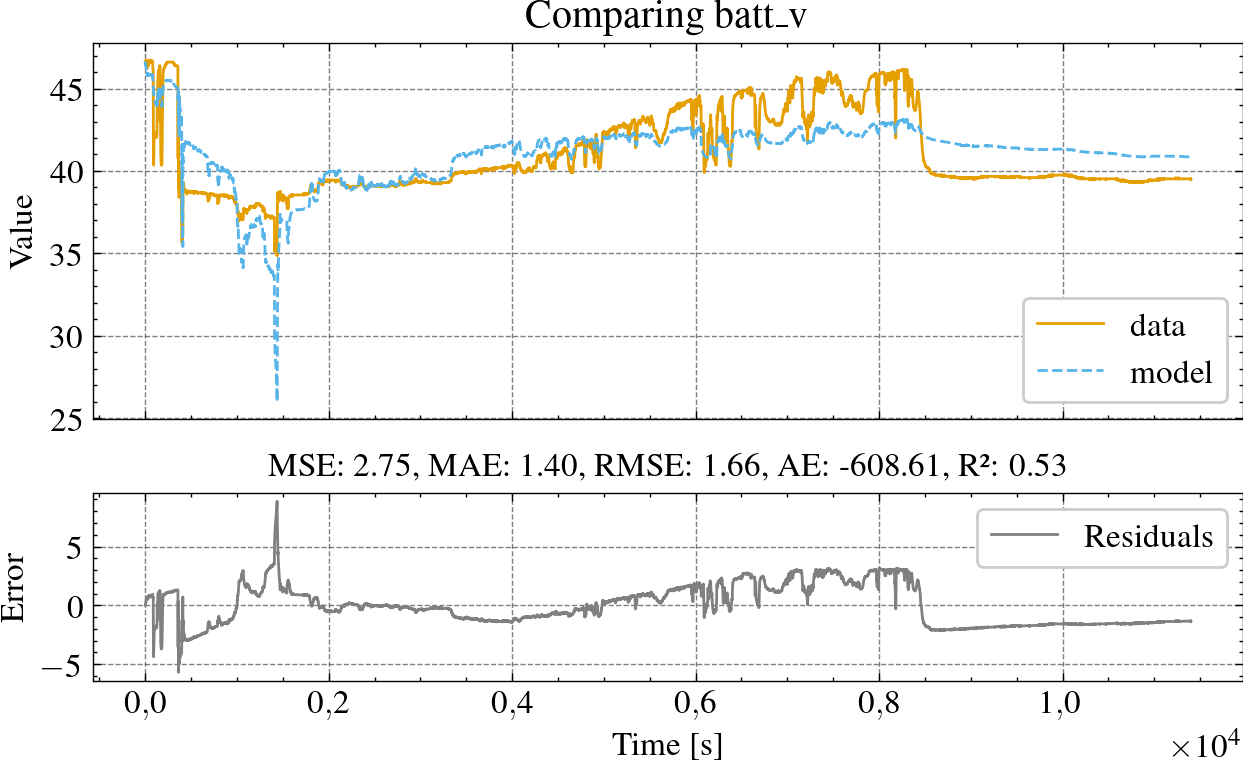

In [28]:
# Simulate the model with the optimized parameters
df_train = df.loc[
    (df.index >= train_section['start']) & (df.index <= train_section['end']),
    ['t'] + data_cols + input_cols
].resample('1s').mean().interpolate(method='time')
compute_df_capacity(df_train, nominal_Q, optimized_initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
T = np.ascontiguousarray(df_train['t'].to_numpy())
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
X0 = Battery.initial_state(
    X0={
        'batt_z': df_train['batt_z'].iloc[0],
        'batt_v': df_train['batt_v'].iloc[0],
    },
    U0=U[:, 0],
    params=model_params | best_params
)
best_fit_data = model_function(T, U, X0, **(model_params | best_params))

# Plot the comparison for each data column
for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

In [29]:
if 'batt_k_V_OC_coeffs' in best_params:
    soc_test = np.linspace(0, 1, 100)
    batt_k_V_OC_coeffs = battery_params['batt_k_V_OC_coeffs']
    ocv_ref = eval_poly(batt_k_V_OC_coeffs, soc_test)
    plt.plot(soc_test, ocv_ref, label='original')

    best_ocv_coeffs = best_params['batt_k_V_OC_coeffs']
    ocv_pred = eval_poly(best_ocv_coeffs, soc_test)
    plt.plot(soc_test, ocv_pred, label='best')

    plt.legend()
    plt.show()


In [30]:
%%time

import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
from pymoo.core.evaluator import Evaluator
from pymoo.parallelization.starmap import StarmapParallelization
from sklearn.metrics import mean_squared_error
import multiprocessing

class BattZOptimization(ElementwiseProblem):
    def __init__(self, section, df, nominal_Q, model_params, best_params, data_cols, input_cols, **kwargs):
        super().__init__(n_var=1, n_obj=1, xl=np.array([0.0]), xu=np.array([1.0]), type_var=Real, **kwargs)
        self.section = section
        self.df = df
        self.nominal_Q = nominal_Q
        self.model_params = model_params
        self.best_params = best_params
        self.data_cols = data_cols
        self.input_cols = input_cols

    def _evaluate(self, x, out, *args, **kwargs):
        batt_z_0 = x[0]

        df_test = self.df.loc[
            (self.df.index >= self.section['start']) & (self.df.index <= self.section['end']),
            ['t'] + self.data_cols + self.input_cols
        ].dropna().resample('1min').mean().interpolate(method='time')

        if df_test.empty:
            out["F"] = np.inf
            return

        compute_df_capacity(df_test, self.nominal_Q, batt_z_0, inplace=True)
        compute_df_soc(df_test, self.nominal_Q, inplace=True)

        T = np.ascontiguousarray(df_test['t'].to_numpy())
        U = np.ascontiguousarray(df_test[self.input_cols].to_numpy().T)

        X0 = Battery.initial_state(
            X0={
                'batt_z': df_test['batt_z'].iloc[0],
                'batt_v': df_test['batt_v'].iloc[0],
            },
            U0=U[:, 0],
            params=self.model_params | self.best_params
        )
        df_pred = model_function(T, U, X0, **(self.model_params | self.best_params))

        out["F"] = mean_squared_error(df_test[self.data_cols].values, df_pred[self.data_cols].values)

# Create a parallel processing pool
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

model_params = battery_params.copy()

# Run optimization for each section
batt_z_0_dict = {}
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    problem = BattZOptimization(
        section, df, nominal_Q, model_params, best_params, data_cols, input_cols, elementwise_runner=runner,
    )

    algorithm = DE(
        pop_size=10,
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.5,
        CR=0.9,
    )

    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=10000,
        n_max_evals=100000
    )

    res = minimize(problem, algorithm, termination=termination, seed=42, verbose=True, save_history=True)

    batt_z_0_dict[section_name] = res.X[0]

    print(f'Optimized batt_z_0 for {section_name}: {res.X[0]}')

pool.close()
pool.join()

print("Final batt_z_0_dict:", batt_z_0_dict)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  1.475881E+01 |  7.8163860925
     2 |       20 |  1.092454E+01 |  7.7679471100
     3 |       30 |  9.2284711356 |  7.7679471100
     4 |       40 |  8.0763132674 |  7.7679471100
     5 |       50 |  7.8542759051 |  7.7679471100
     6 |       60 |  7.8328332887 |  7.7679471100
     7 |       70 |  7.7819883844 |  7.7628444206
     8 |       80 |  7.7699003940 |  7.7628444206
     9 |       90 |  7.7663985160 |  7.7628444206
    10 |      100 |  7.7644644278 |  7.7628444206
    11 |      110 |  7.7636595660 |  7.7616745843
    12 |      120 |  7.7633919636 |  7.7612246660
    13 |      130 |  7.7633472875 |  7.7612246660
    14 |      140 |  7.7625557436 |  7.7584854889
    15 |      150 |  7.7621488158 |  7.7584854889
    16 |      160 |  7.7621074288 |  7.7584854889
    17 |      170 |  7.7616656583 |  7.7584854889
    18 |      180 |  7.7616504272 |  7.7584854889
    19 |      190 |  7.7616350192 |  7.7584854889


{'D': 0.691966452690918, 'E': 0.3859415688441433, 'F': 0.7072066049476493, 'F1': 0.9973455335105654, 'F2': 0.999994721472924}
/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d.pdf


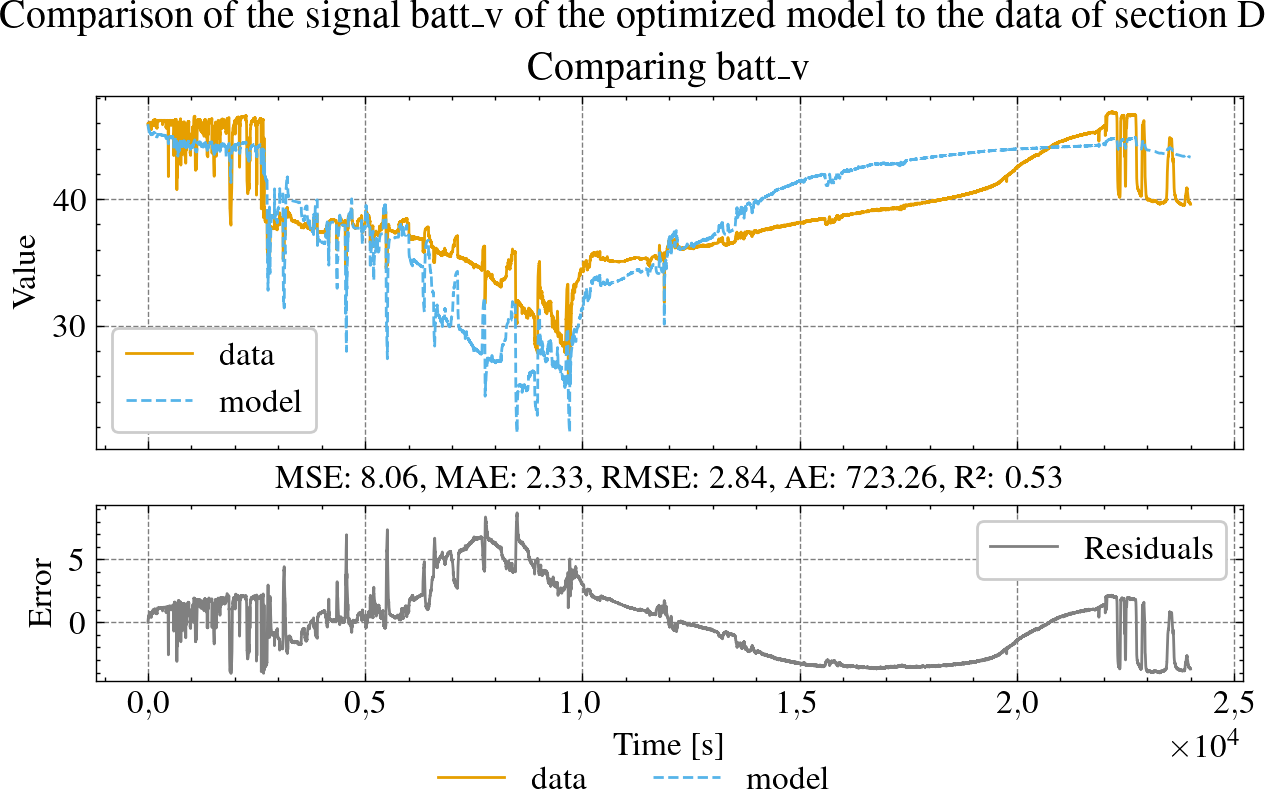

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_e.pdf


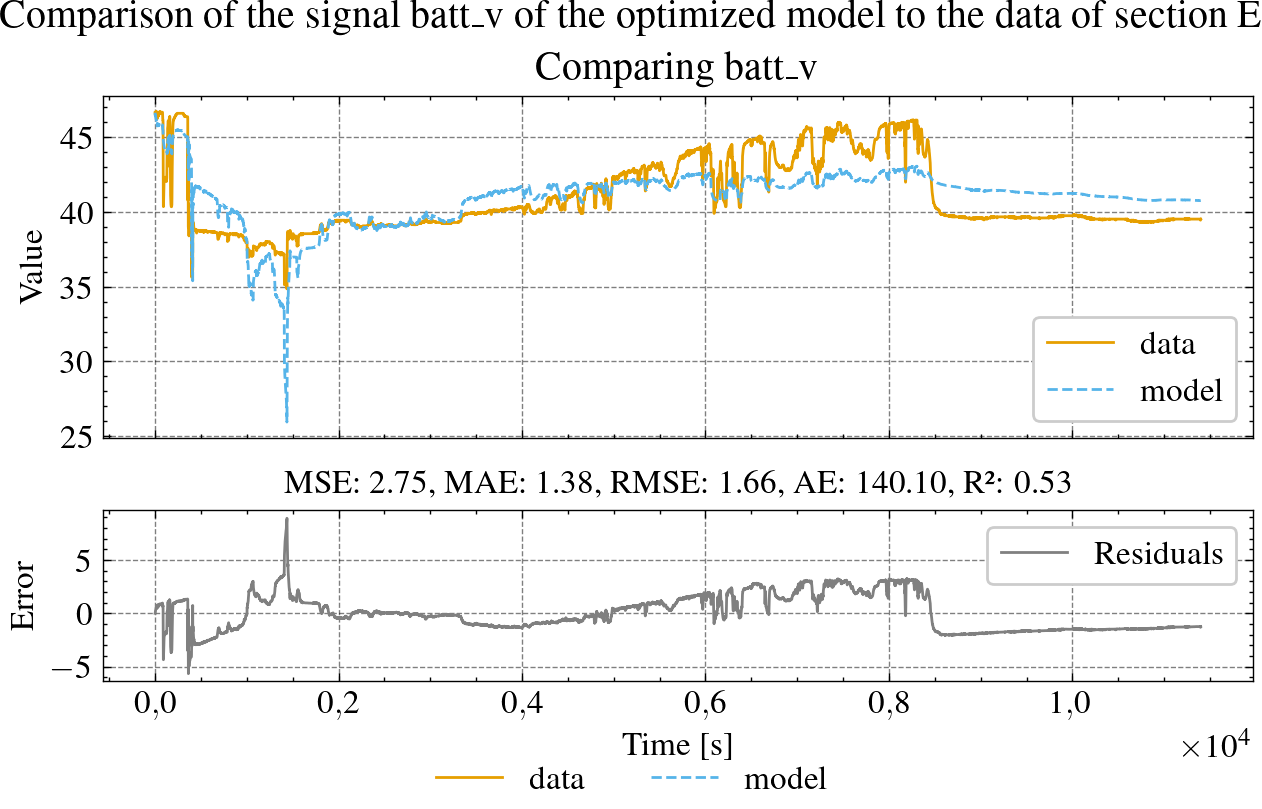

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f.pdf


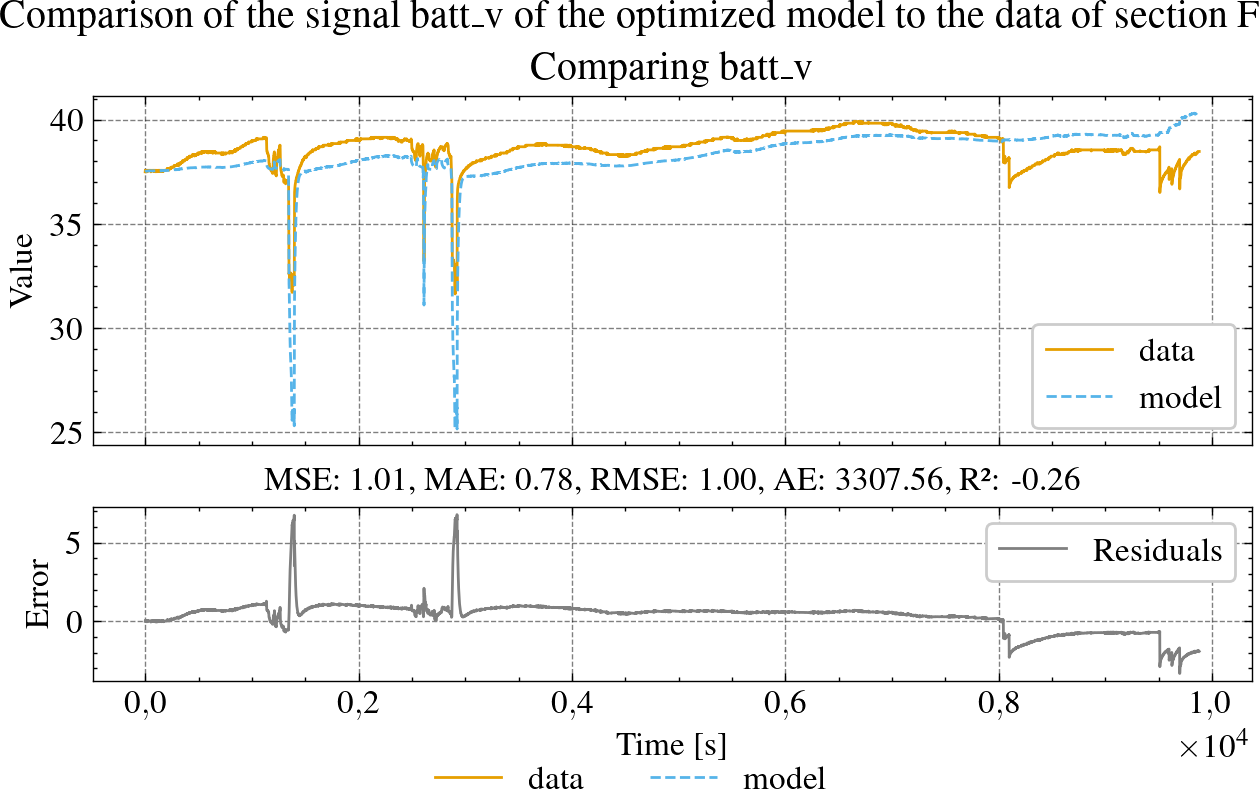

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f1.pdf


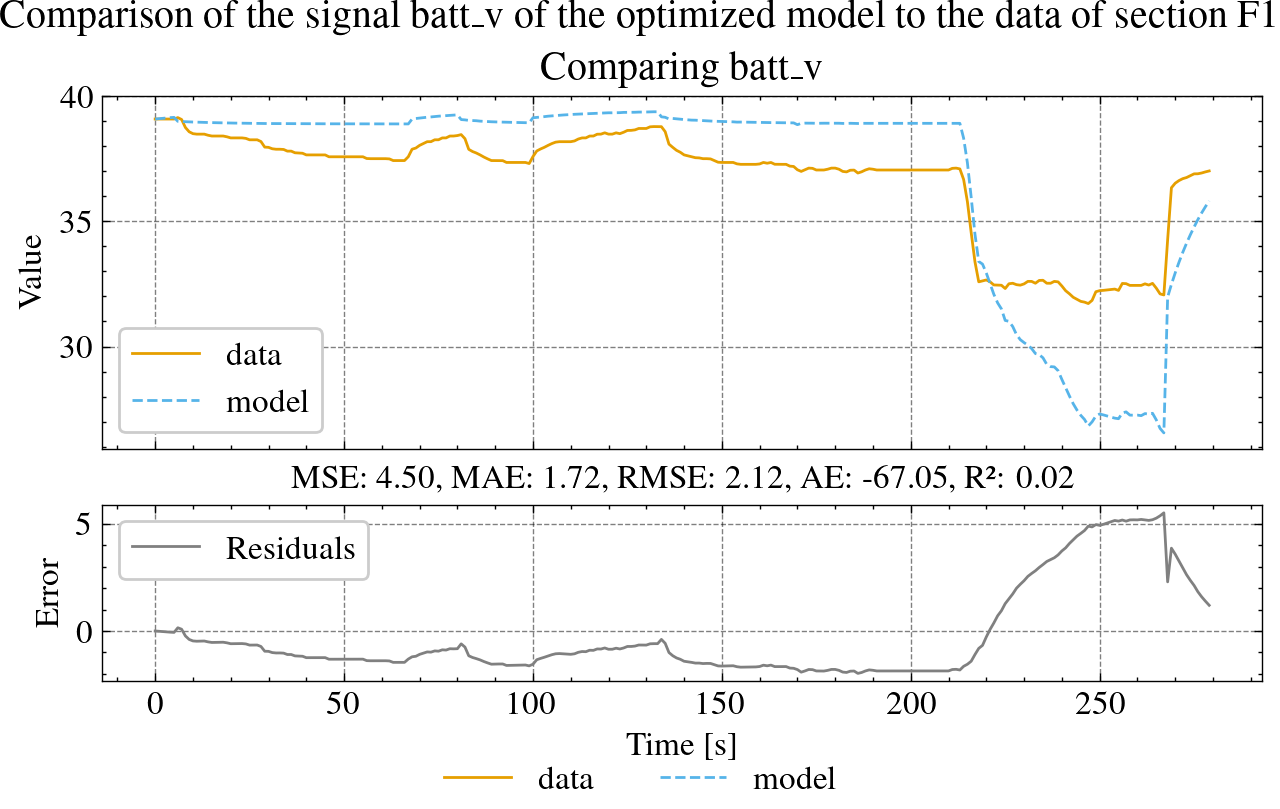

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f2.pdf


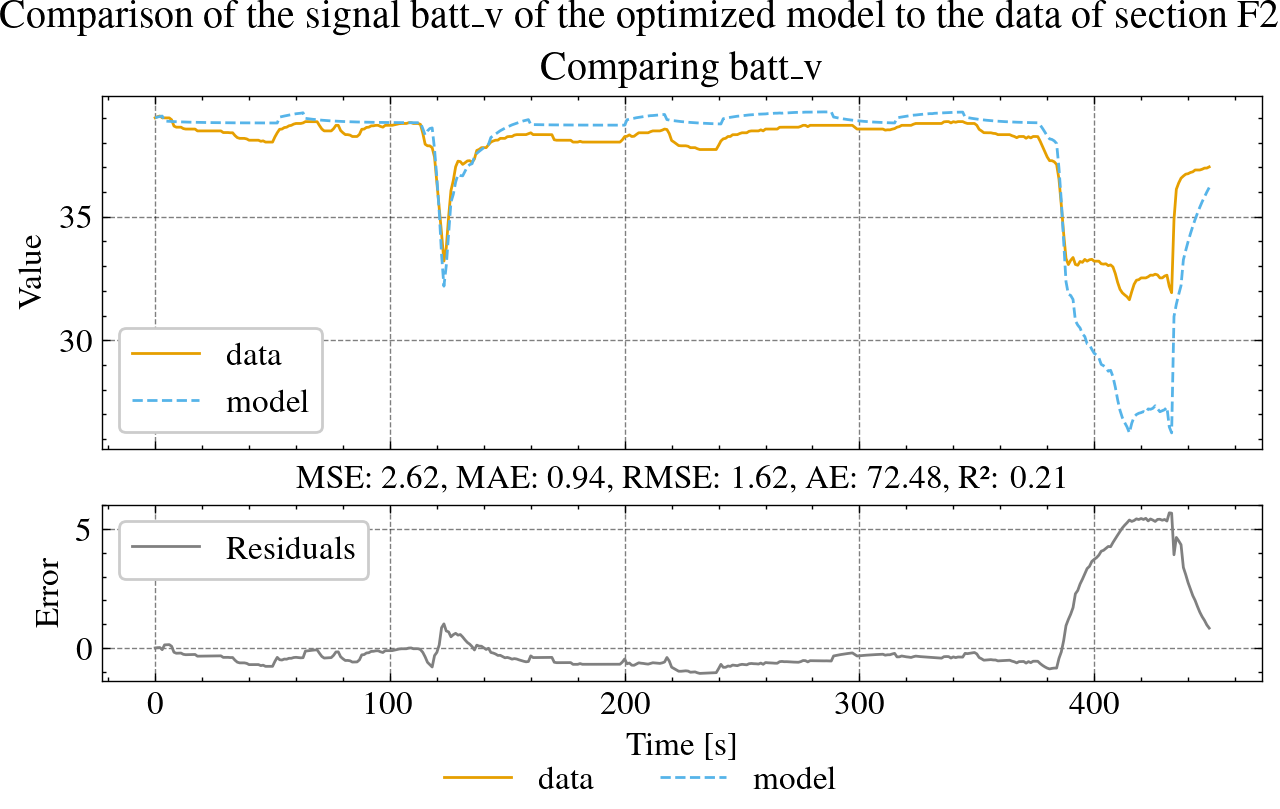

In [31]:
print(batt_z_0_dict)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')
    batt_z_0 = batt_z_0_dict[section_name]

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue
    compute_df_capacity(df_test, nominal_Q, batt_z_0, inplace=True)
    compute_df_soc(df_test, nominal_Q, inplace=True)

    T = np.ascontiguousarray(df_test['t'].to_numpy())
    U = np.ascontiguousarray(df_test[input_cols].to_numpy().T)
    X0 = Battery.initial_state(
        X0={
            'batt_z': df_test['batt_z'].iloc[0],
            'batt_v': df_test['batt_v'].iloc[0],
        }, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(model_params | best_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/battery_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )
